In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.

train_list = open("train_list.txt").readlines()
test_list = open("test_list.txt").readlines()

train_set1 = SubsetSC("training")
test_set1 = SubsetSC("testing")

train_set = list(train_set1[i-1] for i in list(map(int, train_list)))
test_set = list(test_set1[i-1] for i in list(map(int, test_list)))
print(len(train_set))
print(len(test_set))
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

12000
4000


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


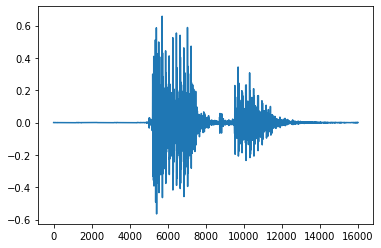

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, label,*_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)
label

16000

The last file is someone saying “visual”.




In [ ]:
waveform_last,sr,label ,*_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)
label

'zero'

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.07936507936507936/20 [00:07<24:36, 74.10s/it]    

Train Epoch: 1 [0/12000 (0%)]	Loss: 3.852711


  2%|▏         | 0.42857142857142855/20 [00:08<02:09,  6.61s/it]

Train Epoch: 1 [5120/12000 (43%)]	Loss: 3.218915


  4%|▍         | 0.7777777777777768/20 [00:08<00:44,  2.34s/it]

Train Epoch: 1 [10240/12000 (85%)]	Loss: 2.773506


  6%|▌         | 1.1269841269841248/20 [00:09<00:28,  1.49s/it]


Test Epoch: 1	Accuracy: 761/4000 (19%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 2.642538


  7%|▋         | 1.4126984126984095/20 [00:09<00:26,  1.45s/it]

Train Epoch: 2 [5120/12000 (43%)]	Loss: 2.336667


  9%|▊         | 1.7301587301587258/20 [00:09<00:25,  1.40s/it]

Train Epoch: 2 [10240/12000 (85%)]	Loss: 2.238344


 10%|█         | 2.0317460317460263/20 [00:10<00:21,  1.19s/it]


Test Epoch: 2	Accuracy: 1406/4000 (35%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 1.958552


 12%|█▏        | 2.4444444444444375/20 [00:10<00:24,  1.39s/it]

Train Epoch: 3 [5120/12000 (43%)]	Loss: 1.997065


 14%|█▍        | 2.761904761904754/20 [00:11<00:23,  1.36s/it]

Train Epoch: 3 [10240/12000 (85%)]	Loss: 1.694833


 16%|█▌        | 3.111111111111102/20 [00:11<00:18,  1.12s/it]


Test Epoch: 3	Accuracy: 1928/4000 (48%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 1.537832


 17%|█▋        | 3.4920634920634814/20 [00:12<00:19,  1.18s/it]

Train Epoch: 4 [5120/12000 (43%)]	Loss: 1.631808


 19%|█▉        | 3.777777777777766/20 [00:12<00:18,  1.15s/it] 

Train Epoch: 4 [10240/12000 (85%)]	Loss: 1.436554


 21%|██        | 4.14285714285713/20 [00:12<00:16,  1.05s/it] 


Test Epoch: 4	Accuracy: 2187/4000 (55%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 1.373495


 22%|██▏       | 4.44444444444443/20 [00:13<00:17,  1.11s/it]  

Train Epoch: 5 [5120/12000 (43%)]	Loss: 1.448369


 24%|██▍       | 4.841269841269826/20 [00:13<00:16,  1.08s/it]

Train Epoch: 5 [10240/12000 (85%)]	Loss: 1.357681


 25%|██▌       | 5.079365079365063/20 [00:13<00:15,  1.01s/it]


Test Epoch: 5	Accuracy: 2164/4000 (54%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 1.254721


 27%|██▋       | 5.492063492063474/20 [00:14<00:15,  1.10s/it]

Train Epoch: 6 [5120/12000 (43%)]	Loss: 1.209394


 29%|██▉       | 5.777777777777759/20 [00:14<00:15,  1.11s/it]

Train Epoch: 6 [10240/12000 (85%)]	Loss: 0.934326


 31%|███       | 6.142857142857123/20 [00:14<00:14,  1.03s/it]


Test Epoch: 6	Accuracy: 2493/4000 (62%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.964602


 32%|███▏      | 6.460317460317439/20 [00:15<00:14,  1.09s/it]

Train Epoch: 7 [5120/12000 (43%)]	Loss: 1.130668


 34%|███▎      | 6.746031746031724/20 [00:15<00:15,  1.14s/it]

Train Epoch: 7 [10240/12000 (85%)]	Loss: 1.020682


 36%|███▌      | 7.126984126984103/20 [00:16<00:13,  1.03s/it]


Test Epoch: 7	Accuracy: 2512/4000 (63%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.894770


 37%|███▋      | 7.428571428571404/20 [00:16<00:13,  1.11s/it]

Train Epoch: 8 [5120/12000 (43%)]	Loss: 0.961764


 39%|███▉      | 7.825396825396799/20 [00:16<00:13,  1.07s/it]

Train Epoch: 8 [10240/12000 (85%)]	Loss: 0.923196


 40%|████      | 8.063492063492037/20 [00:17<00:12,  1.01s/it]


Test Epoch: 8	Accuracy: 2537/4000 (63%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.748628


 42%|████▏     | 8.476190476190448/20 [00:17<00:12,  1.10s/it]

Train Epoch: 9 [5120/12000 (43%)]	Loss: 0.951918


 44%|████▍     | 8.761904761904733/20 [00:17<00:12,  1.14s/it]

Train Epoch: 9 [10240/12000 (85%)]	Loss: 1.020185


 46%|████▌     | 9.126984126984096/20 [00:18<00:11,  1.04s/it]


Test Epoch: 9	Accuracy: 2597/4000 (65%)

Train Epoch: 10 [0/12000 (0%)]	Loss: 0.743287


 47%|████▋     | 9.428571428571397/20 [00:18<00:11,  1.09s/it]

Train Epoch: 10 [5120/12000 (43%)]	Loss: 0.821448


 49%|████▉     | 9.825396825396792/20 [00:18<00:11,  1.08s/it]

Train Epoch: 10 [10240/12000 (85%)]	Loss: 0.825419


 50%|█████     | 10.06349206349203/20 [00:19<00:10,  1.02s/it]


Test Epoch: 10	Accuracy: 2257/4000 (56%)

Train Epoch: 11 [0/12000 (0%)]	Loss: 0.757363


 52%|█████▏    | 10.47619047619044/20 [00:19<00:10,  1.10s/it] 

Train Epoch: 11 [5120/12000 (43%)]	Loss: 0.775645


 54%|█████▍    | 10.761904761904725/20 [00:19<00:10,  1.13s/it]

Train Epoch: 11 [10240/12000 (85%)]	Loss: 0.814380


 56%|█████▌    | 11.12698412698409/20 [00:20<00:09,  1.02s/it] 


Test Epoch: 11	Accuracy: 2577/4000 (64%)

Train Epoch: 12 [0/12000 (0%)]	Loss: 0.624507


 57%|█████▋    | 11.444444444444406/20 [00:20<00:09,  1.08s/it]

Train Epoch: 12 [5120/12000 (43%)]	Loss: 0.773933


 59%|█████▉    | 11.841269841269801/20 [00:21<00:08,  1.07s/it]

Train Epoch: 12 [10240/12000 (85%)]	Loss: 0.645555


 60%|██████    | 12.079365079365038/20 [00:21<00:08,  1.01s/it]


Test Epoch: 12	Accuracy: 2556/4000 (64%)

Train Epoch: 13 [0/12000 (0%)]	Loss: 0.553383


 62%|██████▏   | 12.476190476190434/20 [00:21<00:09,  1.30s/it]

Train Epoch: 13 [5120/12000 (43%)]	Loss: 0.745143


 64%|██████▍   | 12.809523809523766/20 [00:22<00:09,  1.28s/it]

Train Epoch: 13 [10240/12000 (85%)]	Loss: 0.789052


 66%|██████▌   | 13.111111111111066/20 [00:22<00:08,  1.22s/it]


Test Epoch: 13	Accuracy: 2690/4000 (67%)

Train Epoch: 14 [0/12000 (0%)]	Loss: 0.676977


 67%|██████▋   | 13.460317460317414/20 [00:23<00:08,  1.37s/it]

Train Epoch: 14 [5120/12000 (43%)]	Loss: 0.653520


 69%|██████▉   | 13.77777777777773/20 [00:23<00:08,  1.37s/it] 

Train Epoch: 14 [10240/12000 (85%)]	Loss: 0.602532


 71%|███████   | 14.126984126984079/20 [00:23<00:06,  1.16s/it]


Test Epoch: 14	Accuracy: 2734/4000 (68%)

Train Epoch: 15 [0/12000 (0%)]	Loss: 0.530863


 72%|███████▏  | 14.412698412698363/20 [00:24<00:06,  1.19s/it]

Train Epoch: 15 [5120/12000 (43%)]	Loss: 0.563630


 74%|███████▍  | 14.793650793650743/20 [00:24<00:05,  1.15s/it]

Train Epoch: 15 [10240/12000 (85%)]	Loss: 0.637494


 76%|███████▌  | 15.14285714285709/20 [00:25<00:05,  1.05s/it]


Test Epoch: 15	Accuracy: 2558/4000 (64%)

Train Epoch: 16 [0/12000 (0%)]	Loss: 0.728953


 77%|███████▋  | 15.444444444444391/20 [00:25<00:05,  1.10s/it]

Train Epoch: 16 [5120/12000 (43%)]	Loss: 0.537812


 79%|███████▉  | 15.841269841269787/20 [00:25<00:04,  1.08s/it]

Train Epoch: 16 [10240/12000 (85%)]	Loss: 0.520065


 81%|████████  | 16.158730158730105/20 [00:26<00:04,  1.08s/it]


Test Epoch: 16	Accuracy: 2618/4000 (65%)

Train Epoch: 17 [0/12000 (0%)]	Loss: 0.467486


 82%|████████▏ | 16.44444444444439/20 [00:26<00:03,  1.11s/it] 

Train Epoch: 17 [5120/12000 (43%)]	Loss: 0.532178


 84%|████████▍ | 16.841269841269785/20 [00:26<00:03,  1.09s/it]

Train Epoch: 17 [10240/12000 (85%)]	Loss: 0.645418


 85%|████████▌ | 17.079365079365022/20 [00:27<00:02,  1.03s/it]


Test Epoch: 17	Accuracy: 2722/4000 (68%)

Train Epoch: 18 [0/12000 (0%)]	Loss: 0.541151


 87%|████████▋ | 17.476190476190418/20 [00:27<00:02,  1.11s/it]

Train Epoch: 18 [5120/12000 (43%)]	Loss: 0.529188


 89%|████████▉ | 17.761904761904702/20 [00:27<00:02,  1.14s/it]

Train Epoch: 18 [10240/12000 (85%)]	Loss: 0.485864


 91%|█████████ | 18.126984126984066/20 [00:28<00:01,  1.03s/it]


Test Epoch: 18	Accuracy: 2665/4000 (67%)

Train Epoch: 19 [0/12000 (0%)]	Loss: 0.394899


 92%|█████████▏| 18.428571428571367/20 [00:28<00:01,  1.12s/it]

Train Epoch: 19 [5120/12000 (43%)]	Loss: 0.473693


 94%|█████████▍| 18.825396825396762/20 [00:29<00:01,  1.09s/it]

Train Epoch: 19 [10240/12000 (85%)]	Loss: 0.563866


 95%|█████████▌| 19.063492063492/20 [00:29<00:00,  1.02s/it]  


Test Epoch: 19	Accuracy: 2761/4000 (69%)

Train Epoch: 20 [0/12000 (0%)]	Loss: 0.482947


 97%|█████████▋| 19.460317460317395/20 [00:29<00:00,  1.13s/it]

Train Epoch: 20 [5120/12000 (43%)]	Loss: 0.509215


 99%|█████████▊| 19.74603174603168/20 [00:30<00:00,  1.15s/it] 

Train Epoch: 20 [10240/12000 (85%)]	Loss: 0.462191


100%|█████████▉| 19.999999999999932/20 [00:30<00:00,  1.52s/it]



Test Epoch: 20	Accuracy: 2773/4000 (69%)



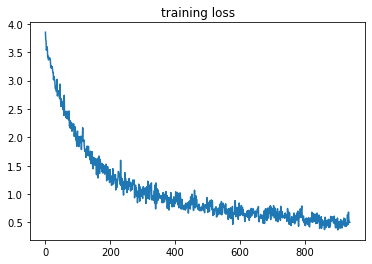

In [ ]:
log_interval = 20
n_epoch =20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");